<h1 align="center"> Failure Prediction In Pumps Using Multi-Variate Statistics</h1>

Since the Recent, Decades Condition Based Monitoring of Hydraulics System has been gaining popularity .</br>
Thereby, machine downtimes and maintenance costs are reduced, but also planning security of production can be enhanced considerably.</br>
In General, there are two condition monitoring philosophies</br>
<ol>
    <li> <b>The Model Based approach</b> which requires detailed physical and mathematical knowledge about the system's behaiviour which is difficult to obtain with sufficient details for increasingly complex system</li>
    <li> <b>The Statistical Approach</b> which is based on analysis of previously observed faults and associated measurement data and requires a sufficient quantity of historical data
    
</ol>

### Aim Of this Project

<b>The Aim of the project is to use the methods of Statistical Learning to develop a model for predicting the failure of a Pump system based on the data recived by the sensor and compare the results predicted by the models</b>

### Outline
<ol>
    <li>Understanding The Data</li>
    <li>Cleaning The Data</li>
    <li>Feature Engineering</li>
    <li>Dealing With Class Imbalance: Using SMOTE</li>    
    <li>Dealing With Outliers: Using IQR</li>
    <li>Training Our Model</li>
    <li>Testing and Cross-Validation</li>
</ol>

## References

Hands on Machine Learning with Scikit-Learn & TensorFlow by Aurélien Géron (O'Reilly). CopyRight 2017 Aurélien Géron</br>
Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn by Coding-Maniac</br>
auprc, 5-fold c-v, and resampling methods by Jeremy Lane (Kaggle Notebook)</br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#importing the data set
df=pd.read_csv('sensor.csv')
df.pop(df.columns[0])
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [2]:
df['machine_status'].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)


### Understanding the Data Set 
The Sensor data Comprises of 2,20,320 observations descrived by 54 features. One is the dependent variable (target Class) and the rest are the independent variables. Out of the 53 Independent variables 52 are the data collected from the sensors and 1 is the time at which the observation was taken.

<h2 align="center"> Elementary Data Analysis(EDA)</h2>

EDA is the process of performing investigation on the data-set so as to
<ol>
    <li>Uncover the underlying data structures and patterns of data</li>
    <li>Identify Important Variables</li>
    <li>Identify Anomalies</li>
    <li>Set the stage for model development</li>
</ol>

Generally speaking any method of ooking at data that doesn ot include formal statistical modeling and inference may fall under the umbrella of exploratory data analysis.

In [3]:
df.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,215725.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,14.799210,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,2.091963,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,0.000000,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,15.053530,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,15.082470,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,15.118630,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,25.000000,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


### Cleaning the Dataset
Data cleansing or data cleaning is the process of detecting and correcting corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data.</br>

Having clean data will ultimately increase overall productivity and allow for the highest quality information in your decision-making. Benefits include: Removal of errors when multiple sources of data are at play. Fewer errors make for happier clients and less-frustrated employees.

In [4]:
#Looking for Missing Data
df.isnull().sum()

timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16
sensor_38             27


<b>-Sensor 15 has No values Hence we will drop this column</br>
-Sensor 50 also have a huge no of Missing values which would lead to problems hence we will drop this column as well</br>
-The Null values from rest of the columns would be dropped
</b>

In [5]:
df=df.drop(['sensor_15','sensor_50','sensor_37'],axis=1)
df.head(2)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,201.3889,NORMAL


In [6]:
df=df.dropna()
df.isnull().sum()

timestamp         0
sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0
sensor_48         0
sensor_49         0
sensor_51         0


In [7]:
df.shape

(195815, 51)

<b>After Dealing with the null values we have 195815 observations in our data-set which are now defined by 52 features</b>
#### Now we will also look after the data type of each column

In [8]:
df.dtypes

timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36         float64
sensor_38         float64
sensor_39   

### Seperating the date and time column for better Visualisation

In [9]:
df['year']=pd.to_datetime(df['timestamp']).dt.year
df['month']=pd.to_datetime(df['timestamp']).dt.month
df['week']=pd.to_datetime(df['timestamp']).dt.isocalendar().week
df['Day']=pd.to_datetime(df['timestamp']).dt.dayofyear
df['hour']=pd.to_datetime(df['timestamp']).dt.hour
df.head(2)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_47,sensor_48,sensor_49,sensor_51,machine_status,year,month,week,Day,hour
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,38.19444,157.9861,67.70834,201.3889,NORMAL,2018,4,13,91,0
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,38.19444,157.9861,67.70834,201.3889,NORMAL,2018,4,13,91,0


### Introducing a New Column Time of Day Which tells during which time of the day the failure occurs
<ul>
    <li><b>0 = Morning</b></li>
    <li><b>1 = Afternoon</b></li>
    <li><b>2 = Night</b></li>
</ul>

In [10]:
def partofday (row):
    if  5 <= row['hour'] <= 12:
        return 0
    elif 13 <= row['hour'] <= 20:
        return 1
    elif row['hour'] <= 4 or row['hour'] >= 21:
        return 2
    else:
        return 'Other'
df['partofday'] = df.apply (lambda row: partofday(row), axis=1)
df[df['machine_status']=='BROKEN']

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_48,sensor_49,sensor_51,machine_status,year,month,week,Day,hour,partofday
17155,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,16.869210,...,409.14350,121.52780,324.6528,BROKEN,2018,4,15,102,21,2
24510,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,14.185470,...,59.89583,44.56018,183.7384,BROKEN,2018,4,16,108,0,2
69318,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,15.147570,...,144.67590,49.76852,257.5231,BROKEN,2018,5,20,139,3,2
77790,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,15.943290,...,155.38190,65.68287,267.3611,BROKEN,2018,5,21,145,0,2
141131,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,0.036169,...,99.53703,44.84954,174.7685,BROKEN,2018,7,27,189,0,2
166440,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,15.697340,...,230.32410,69.73380,205.7292,BROKEN,2018,7,30,206,14,1


In [11]:
df['week']=df['week'].astype(int)
df['week'].dtype

dtype('int64')

Text(0.5, 1.0, 'sensor_20')

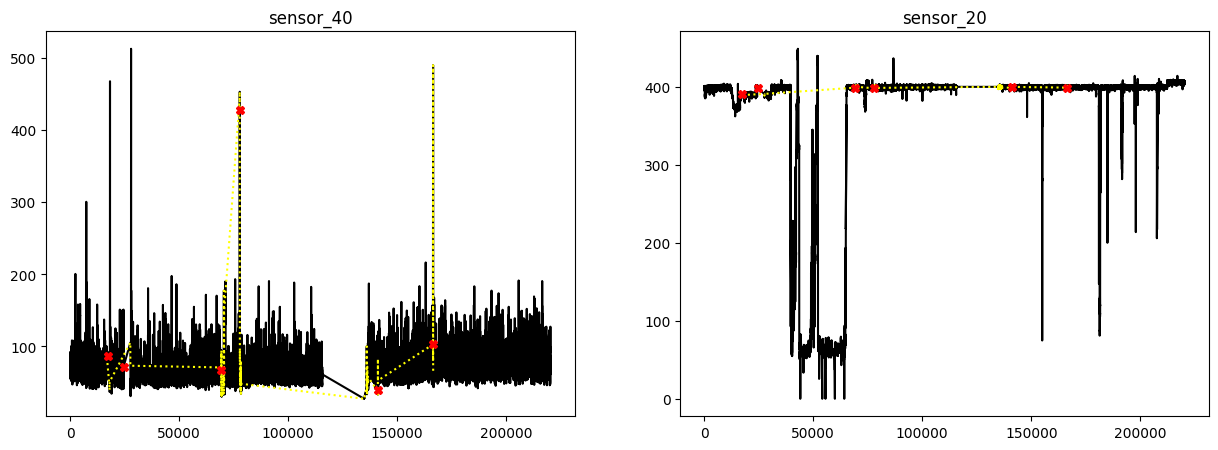

In [12]:
#LOOKIng at a sensor data to identify
import datetime
normal = df[df['machine_status']=='NORMAL']
broken = df[df['machine_status']=='BROKEN']
recovering = df[df['machine_status']=='RECOVERING']
# b=df.timestamp
sensor='sensor_40'
fig,ax= plt.subplots(1,2,figsize=(15,5))
ax[0].plot(df['sensor_40'],color='black')
ax[0].plot(recovering['sensor_40'],linestyle='dotted',color='yellow')
ax[0].plot(broken['sensor_40'],linestyle='none',marker='X',color='red')
ax[1].plot(df['sensor_20'],color='black')
ax[1].plot(recovering['sensor_20'],linestyle='dotted',color='yellow')
ax[1].plot(broken['sensor_20'],linestyle='none',marker='X',color='red')
ax[0].set_title('sensor_40')
ax[1].set_title('sensor_20')

### Looking at the Number of failures


<AxesSubplot: xlabel='machine_status', ylabel='count'>

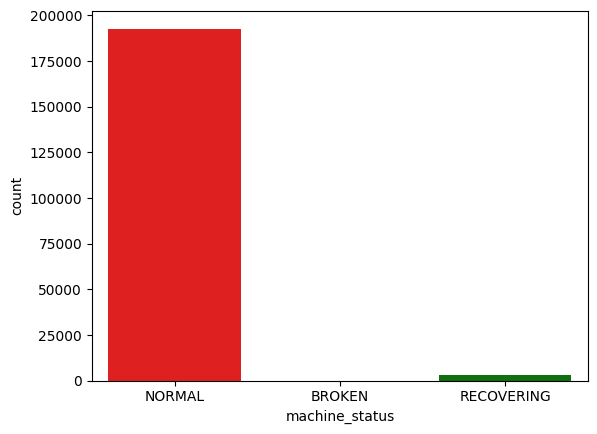

In [13]:
color=['red','blue','green']
sns.countplot(x='machine_status',data=df, palette=color)

### <b>We can clearly see that the data is highly Imbalanced and we need to Deal with it</b>

## Dealing With noise in the sensor reading 


## Feature Selection
The input variables that we give to our machine learning models are called features. Each column in our dataset constitutes a feature. To train an optimal model, we need to make sure that we use only the essential features. If we have too many features, the model can capture the unimportant patterns and learn from noise. The method of choosing the important parameters of our data is called Feature Selection. 

### Feature Selection Models :
<ul>
    <li><b>Supervised Models :</b>Supervised feature selection refers to the method which uses the output label class for feature selection. They use the target variables to identify the variables which can increase the efficiency of the model</li>
    <li><b>Unsupervised Models :</b>Unsupervised feature selection refers to the method which does not need the output label class for feature selection. We use them for unlabelled data.</li>
</ul>

Supervised Models can be further sub-divided into : </br>
<ul>
    <li>Filter Method</li>
    <li>Wrapper Method</li>
    <li>Intrinsic Method</li>
</ul>

The type of Method Used for Feature Selection Depends on the type of input and output variable:</br>

<b>Numerical Input, Numerical Output</b>
- Pearson’s correlation coefficient (linear)
- Spearman’s rank coefficient (nonlinear).

<b>Numerical Input, Categorical Output</b>
- ANOVA correlation coefficient (linear).
- Kendall’s rank coefficient (nonlinear).

<b>Categorical Input, Categorical Output</b>
- This is a regression predictive modeling problem with categorical input variables.

<b>Categorical Input, Categorical Output</b>
- Chi-Squared test (contingency tables)


<i>For Our Model we will be using ANOVA (analysis of variance) for feature selection</i>

Text(0.5, 1.0, 'Variance')

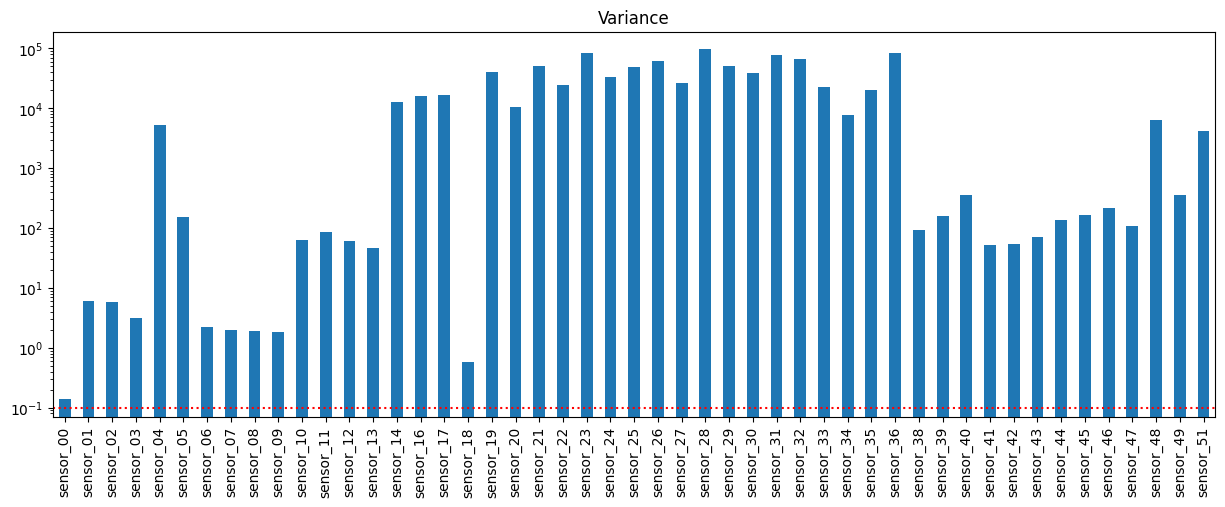

In [14]:
from sklearn.feature_selection import VarianceThreshold
threshold=0.1
selector = VarianceThreshold(threshold)
selector.fit_transform(df.iloc[:,1:50])
fig,ax= plt.subplots(1,1,figsize=(15,5))
ax=pd.Series(selector.variances_,index=df.iloc[:,1:50].columns).plot(kind='bar',logy=True)
ax.axhline(threshold, ls='dotted', c='r')
plt.title('Variance')

Text(0.5, 1.0, 'f_scores')

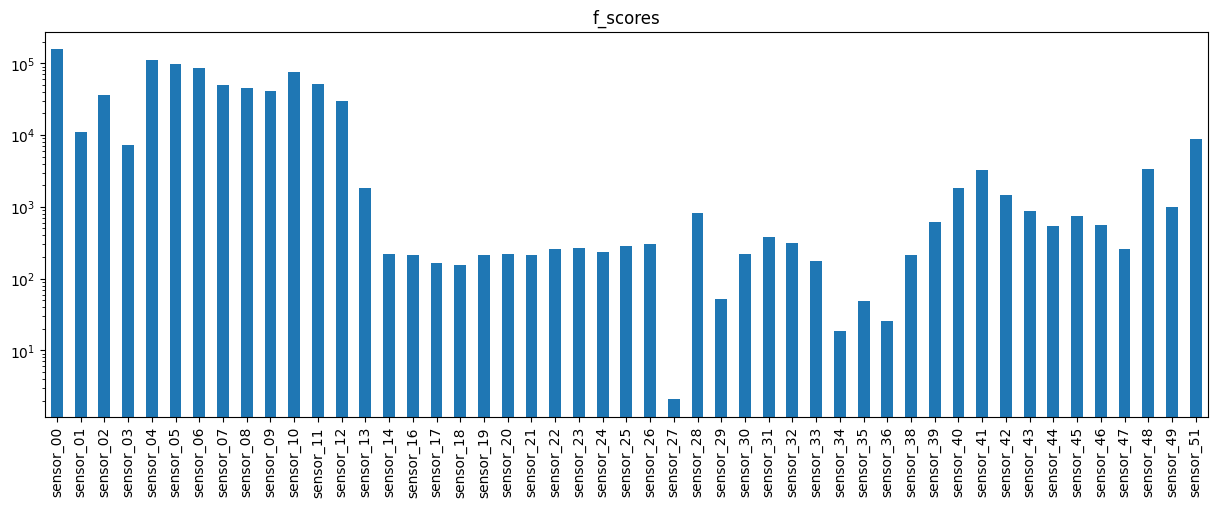

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
selector = SelectKBest(f_classif, k=35)
X=df.iloc[:,1:50]
y=df.machine_status
selector.fit(X,y)
z=selector.scores_
z_roe=[]
for i in range (1,50):
    z_roe.append(df.columns[i])
fig,ax= plt.subplots(1,1,figsize=(15,5))
ax=pd.Series(z,index=z_roe).plot(kind='bar',logy=True)
plt.title('f_scores')

<AxesSubplot: title={'center': 'sensor_27'}, xlabel='machine_status'>

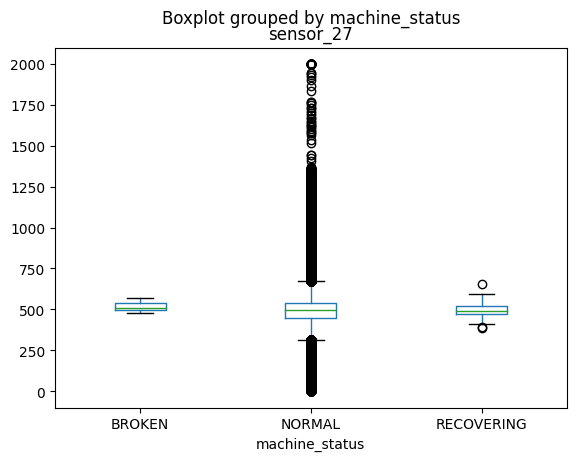

In [16]:
df.boxplot(column='sensor_27',by='machine_status',grid=False) #This sensor has a low test_score

In [17]:
#Drop the Columns with Low f score
df=df.drop(['sensor_27'],axis=1)

<b>Before We Proceed any further We Will Encode the BrokenStatus Feature</b>

In [18]:
def convert(row):
    if row['machine_status']=='BROKEN':
        return 0
    elif row['machine_status']=='NORMAL':
        return 1
    elif row['machine_status']=='RECOVERING':
        return 0
df['result']=df.apply (lambda row: convert(row), axis=1)
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_49,sensor_51,machine_status,year,month,week,Day,hour,partofday,result
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,67.70834,201.3889,NORMAL,2018,4,13,91,0,2,1
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,67.70834,201.3889,NORMAL,2018,4,13,91,0,2,1
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,67.12963,203.7037,NORMAL,2018,4,13,91,0,2,1
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,66.84028,203.1250,NORMAL,2018,4,13,91,0,2,1
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,66.55093,201.3889,NORMAL,2018,4,13,91,0,2,1


In [19]:
df.result.unique()

array([1, 0])

In [20]:
df[df['machine_status']=='BROKEN'].head(3)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_49,sensor_51,machine_status,year,month,week,Day,hour,partofday,result
17155,2018-04-12 21:55:00,0.000000,53.34201,52.82118,43.402775,202.526031,49.79289,3.219039,16.89091,16.86921,...,121.52780,324.6528,BROKEN,2018,4,15,102,21,2,0
24510,2018-04-18 00:30:00,1.093982,42.53472,47.69965,41.449650,206.038757,60.30106,12.304690,15.15480,14.18547,...,44.56018,183.7384,BROKEN,2018,4,16,108,0,2,0
69318,2018-05-19 03:18:00,2.258796,47.26563,52.73437,43.446178,200.115738,66.14643,13.592300,15.91435,15.14757,...,49.76852,257.5231,BROKEN,2018,5,20,139,3,2,0


In [21]:
df[df['machine_status']=='RECOVERING'].head(3)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_49,sensor_51,machine_status,year,month,week,Day,hour,partofday,result
17156,2018-04-12 21:56:00,0.0,53.55902,52.77777,43.402775,204.725098,53.74214,3.045428,17.42621,15.740740,...,133.1019,341.7245,RECOVERING,2018,4,15,102,21,2,0
17157,2018-04-12 21:57:00,0.0,53.55902,52.77777,43.402775,201.137131,52.49996,7.537616,13.53443,9.324364,...,140.0463,466.1458,RECOVERING,2018,4,15,102,21,2,0
17158,2018-04-12 21:58:00,0.0,52.77777,52.69097,43.402770,204.030655,57.19875,7.609953,16.60880,16.203700,...,144.9653,366.0301,RECOVERING,2018,4,15,102,21,2,0


In [22]:
df[df['machine_status']=='NORMAL'].head(3)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_49,sensor_51,machine_status,year,month,week,Day,hour,partofday,result
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,15.56713,...,67.70834,201.3889,NORMAL,2018,4,13,91,0,2,1
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,15.56713,...,67.70834,201.3889,NORMAL,2018,4,13,91,0,2,1
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.39757,638.8889,73.54598,13.32465,16.03733,15.61777,...,67.12963,203.7037,NORMAL,2018,4,13,91,0,2,1


<p>We are now pretty much donen with Adding and removing the Features from Our DATA</p>
<p>Next we will Deal with Class Imbalance And Also Scale Our Data Follwed By Feature Engineering</p>

<b>We Will Create a new Data set and remove all some of the uneccesary Features</b>

In [23]:
df1=df.drop(['timestamp','machine_status','year'],axis=1)

In [24]:
def week(row):
    z=row['week']%4+1
    return z
df1['week']=df.apply(lambda row:week(row),axis=1)
df1['week'].unique()

array([2, 3, 4, 1])

## Now We Will Deal With The Class Imbalance Issue Using SMOTE

### Class Imbalance:
Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class).

### Dealing with Imbalanced Data
Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information. 

### SMOTE: Synthetic Minority Oversampling Technique
SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.
At first the total no. of oversampling observations, N is set up. Generally, it is selected such that the binary class distribution is 1:1. But that could be tuned down based on need. Then the iteration starts by first selecting a positive class instance at random. Next, the KNN’s (by default 5) for that instance is obtained. At last, N of these K instances is chosen to interpolate new synthetic instances. To do that, using any distance metric the difference in distance between the feature vector and its neighbors is calculated. Now, this difference is multiplied by any random value in (0,1] and is added to the previous feature vector. This is pictorially represented below:
<img src='https://editor.analyticsvidhya.com/uploads/77417image1.png' width='500'>


In [26]:
df1.head(2)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_47,sensor_48,sensor_49,sensor_51,month,week,Day,hour,partofday,result
0,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,15.05353,...,38.19444,157.9861,67.70834,201.3889,4,2,91,0,2,1
1,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,15.05353,...,38.19444,157.9861,67.70834,201.3889,4,2,91,0,2,1


In [27]:
df['result'].unique()

array([1, 0])

<AxesSubplot: xlabel='result', ylabel='count'>

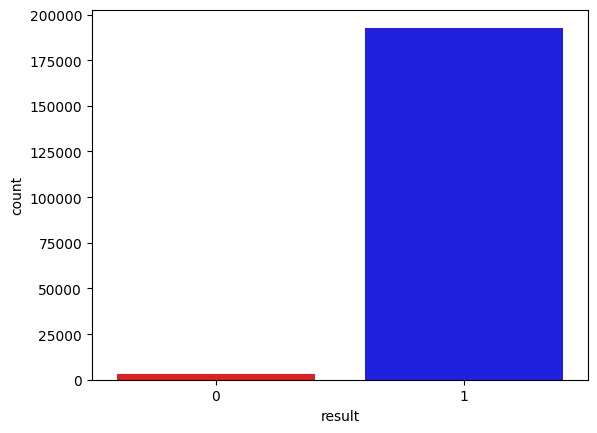

In [28]:
sns.countplot(x='result',data=df1,palette=color)

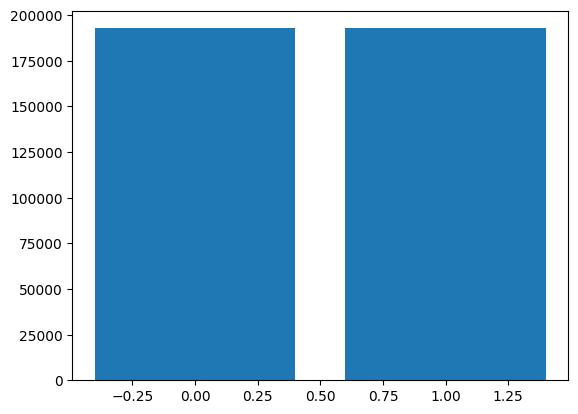

In [29]:
from imblearn.over_sampling import SMOTE
from collections import Counter
# Split the Data into input and output elements
X,y=df1.iloc[:, :-1], df1.iloc[:, -1]
# transform the dataset
# strategy = {-1:60000, 0:192769, 1:80000}
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
plt.bar(counter.keys(), counter.values())
plt.show()


In [30]:
X.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,month,week,Day,hour,partofday
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,50.92593,38.194440,157.9861,67.70834,201.3889,4,2,91,0,2
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,50.92593,38.194440,157.9861,67.70834,201.3889,4,2,91,0,2
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,51.21528,38.194443,155.9606,67.12963,203.7037,4,2,91,0,2
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,51.21528,38.194440,155.9606,66.84028,203.1250,4,2,91,0,2
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,51.79398,38.773150,158.2755,66.55093,201.3889,4,2,91,0,2


In [31]:
df2=pd.concat([X,y],axis=1)
df2

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_47,sensor_48,sensor_49,sensor_51,month,week,Day,hour,partofday,result
0,2.465394,47.092010,53.211800,46.310760,634.375000,76.459750,13.411460,16.131360,15.567130,15.053530,...,38.194440,157.986100,67.708340,201.388900,4,2,91,0,2,1
1,2.465394,47.092010,53.211800,46.310760,634.375000,76.459750,13.411460,16.131360,15.567130,15.053530,...,38.194440,157.986100,67.708340,201.388900,4,2,91,0,2,1
2,2.444734,47.352430,53.211800,46.397570,638.888900,73.545980,13.324650,16.037330,15.617770,15.010130,...,38.194443,155.960600,67.129630,203.703700,4,2,91,0,2,1
3,2.460474,47.092010,53.168400,46.397568,628.125000,76.988980,13.317420,16.247110,15.697340,15.082470,...,38.194440,155.960600,66.840280,203.125000,4,2,91,0,2,1
4,2.445718,47.135410,53.211800,46.397568,636.458300,76.588970,13.353590,16.210940,15.697340,15.082470,...,38.773150,158.275500,66.550930,201.388900,4,2,91,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385533,0.306764,40.085303,37.369790,35.156250,132.493728,37.746748,5.045270,9.840614,10.159504,10.095729,...,33.538309,108.215294,49.635969,36.747684,4,1,110,4,2,0
385534,0.101060,47.095305,48.166632,43.359933,271.990528,0.000000,9.354191,13.833766,12.684975,12.342507,...,34.366967,34.700254,34.344998,40.175971,5,1,139,8,0,0
385535,0.001968,46.872352,47.454315,44.745612,258.344422,0.000000,8.535247,11.317496,11.343036,11.617480,...,32.679108,34.161171,36.865882,32.118059,5,2,145,6,0,0
385536,0.072007,43.667574,44.578692,39.390208,471.062448,0.000000,10.445804,16.377874,16.043742,16.022770,...,32.434333,30.776722,30.487370,31.828701,5,1,139,22,2,0


## Correlation Metrices
<p>A correlation matrix is a common tool used to compare the coefficients of correlation between different features (or attributes) in a dataset. It allows us to visualize how much (or how little) correlation exists between different variables.</p>
<p>This is an important step in pre-processing machine learning pipelines. Since the correlation matrix allows us to identify variables that have high degrees of correlation, they allow us to reduce the number of features we may have in a dataset.</p>
<p>Each row and column represents a variable (or column) in our dataset and the value in the matrix is the coefficient of correlation between the corresponding row and column.
</p>
<p><ul><li>The closer the value is to 1 (or -1), the stronger a relationship.</li>
<li>The closer a number is to 0, the weaker the relationship.</li>
</ul></p>
<p>A negative coefficient will tell us that the relationship is negative, meaning that as one value increases, the other decreases. Similarly, a positive coefficient indicates that as one value increases, so does the other.</p>
<p></p>
<p></p>
<p></p>
<p></p>
<p></p>

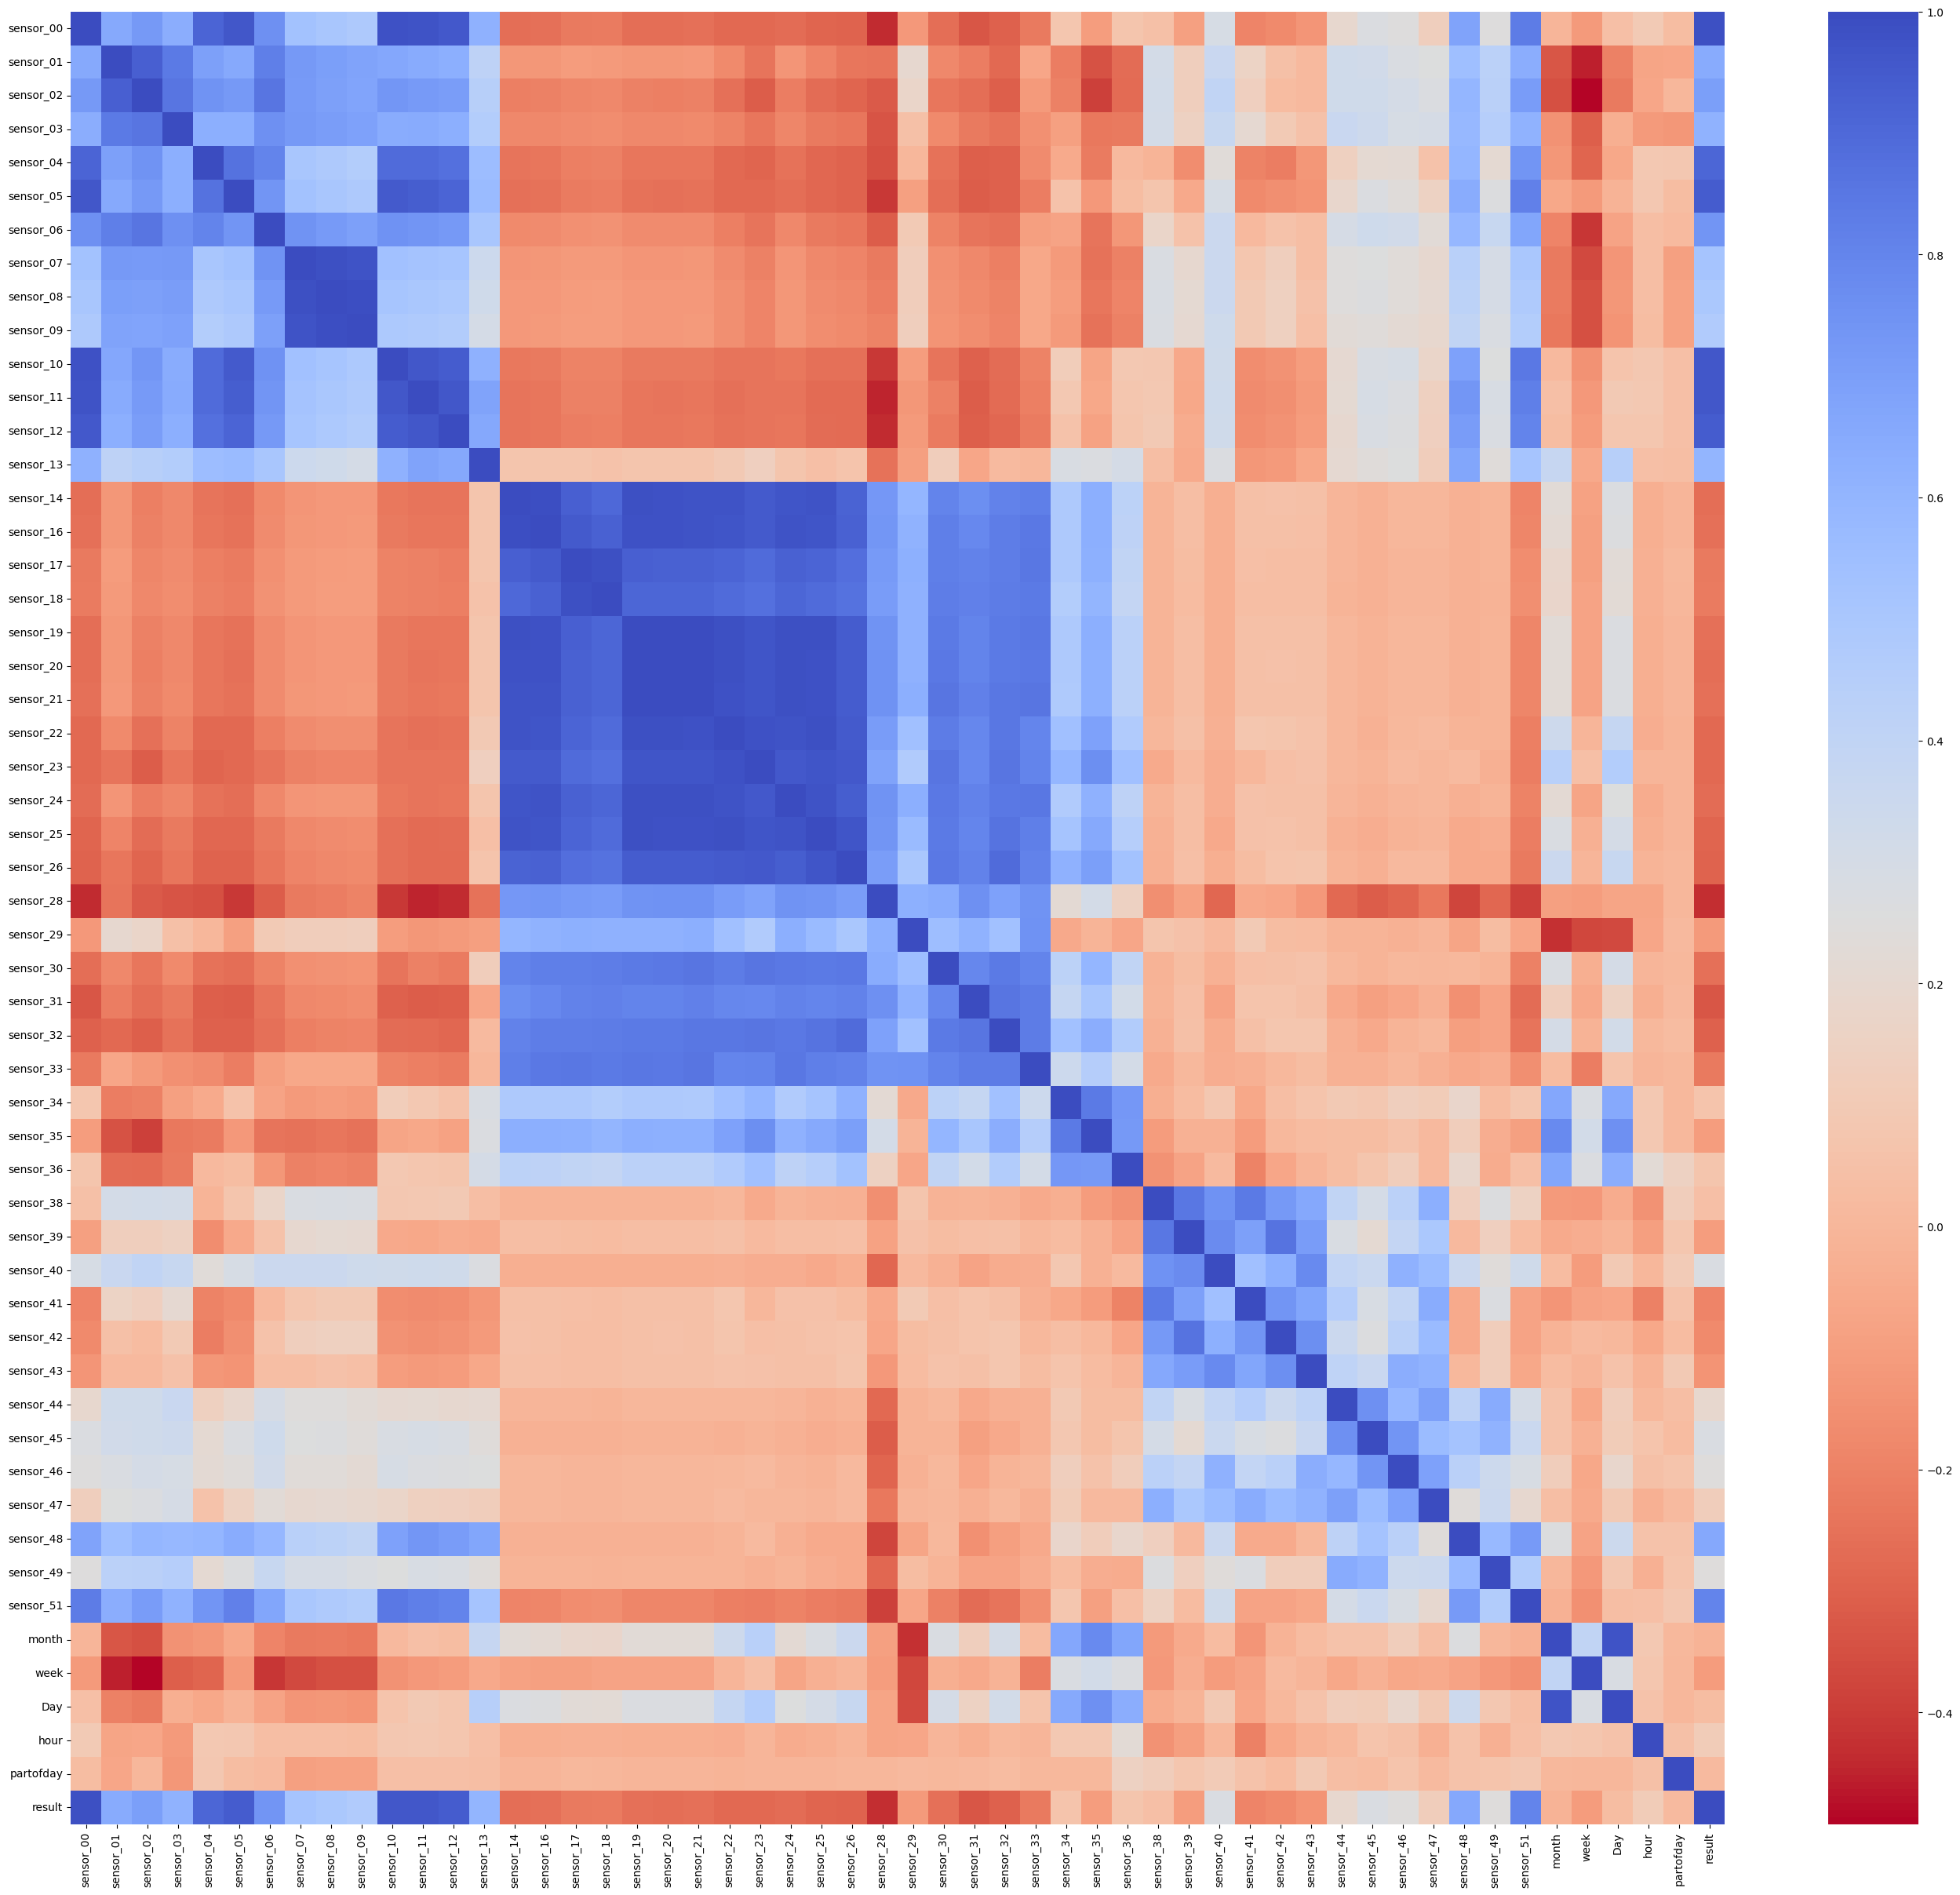

In [32]:
matrix=df2.corr().round(3)
plt.figure(figsize=(34, 30))
sns.heatmap(matrix,cmap='coolwarm_r',annot=False)
plt.show()

<ul>
    <li>Sensor 28,31,32 is negatively correlated</li>
    <li>Sensor 0,4,5,10,11,12 are Positively Correlated</li>
<!--     <li></li>
    <li></li> -->
</ul>
<b>Boxplots :</b>We Will Use BoxPlots to see the relation of these features in Machine Status Whether it's Broken Or not

Text(0.5, 1.0, 'sensor_32 v/s result(negative Correlation)')

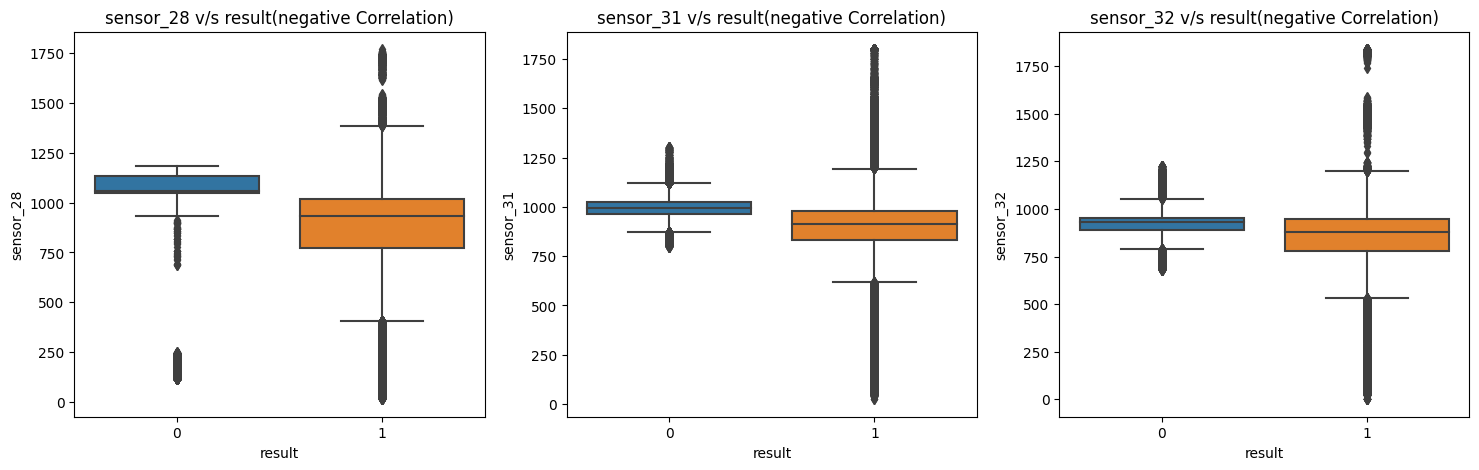

In [33]:
f, axes = plt.subplots(ncols=3, figsize=(18,5))
sns.boxplot(x='result',y='sensor_28',data=df2,ax=axes[0])
axes[0].set_title('sensor_28 v/s result(negative Correlation)')

sns.boxplot(x='result',y='sensor_31',data=df2,ax=axes[1])
axes[1].set_title('sensor_31 v/s result(negative Correlation)')

sns.boxplot(x='result',y='sensor_32',data=df2,ax=axes[2])
axes[2].set_title('sensor_32 v/s result(negative Correlation)')

# sns.boxplot(x='result',y='sensor_41',data=df1)
# axes.set_title('sensor_41 v/s result')

# sns.boxplot(x='result',y='sensor_43',data=df1,ax=axes[1][1])
# axes[1][1].set_title('sensor_43 v/s result')

Text(0.5, 1.0, 'sensor_12 v/s result(positive Correlation)')

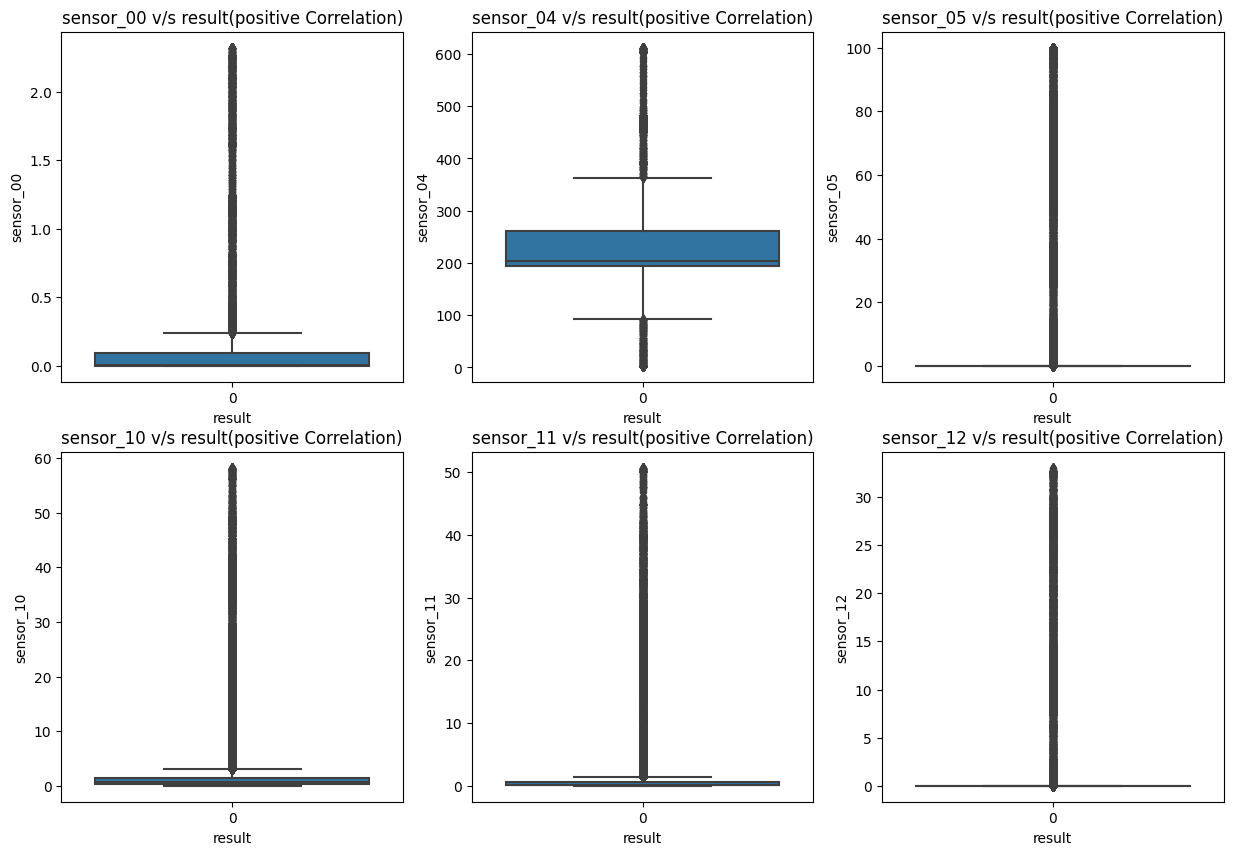

In [34]:
dpx=df2.loc[df2['result']==0]
f, axes = plt.subplots(ncols=3,nrows=2, figsize=(15,10))
sns.boxplot(x='result',y='sensor_00',data=dpx,ax=axes[0][0])
axes[0][0].set_title('sensor_00 v/s result(positive Correlation)')

sns.boxplot(x='result',y='sensor_04',data=dpx,ax=axes[0][1])
axes[0][1].set_title('sensor_04 v/s result(positive Correlation)')

sns.boxplot(x='result',y='sensor_05',data=dpx,ax=axes[0][2])
axes[0][2].set_title('sensor_05 v/s result(positive Correlation)')

sns.boxplot(x='result',y='sensor_10',data=dpx,ax=axes[1][0])
axes[1][0].set_title('sensor_10 v/s result(positive Correlation)')

sns.boxplot(x='result',y='sensor_11',data=dpx,ax=axes[1][1])
axes[1][1].set_title('sensor_11 v/s result(positive Correlation)')

sns.boxplot(x='result',y='sensor_12',data=dpx,ax=axes[1][2])
axes[1][2].set_title('sensor_12 v/s result(positive Correlation)')

### Detecting Anomally in the Sensitive Features
Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models

<b>Interquartile Range method of identifying outliers</b>
<p>This method set up a “fence” outside of Q1 and Q3. Any values that fall outside of this fence are considered outliers. To build this fence we take 1.5 times the IQR and then subtract this value from Q1 and add this value to Q3. This gives us the minimum and maximum fence posts that we compare each observation to. Any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers. This is the method that Minitab uses to identify outliers by default. </p>

<b>Outlier Removal Trade-off</b>

The process of removing outliers from a dataset can have several tradeoffs, which are important to consider before deciding to remove outliers. 

<ul>
    <li>Loss of Information</li>
    <li>Reduced Variability</li>
    <li>Biased Results</li>
    <li>Overfitting</li>

</ul>

Text(0.5, 1.0, 'sensor_10 Distribution')

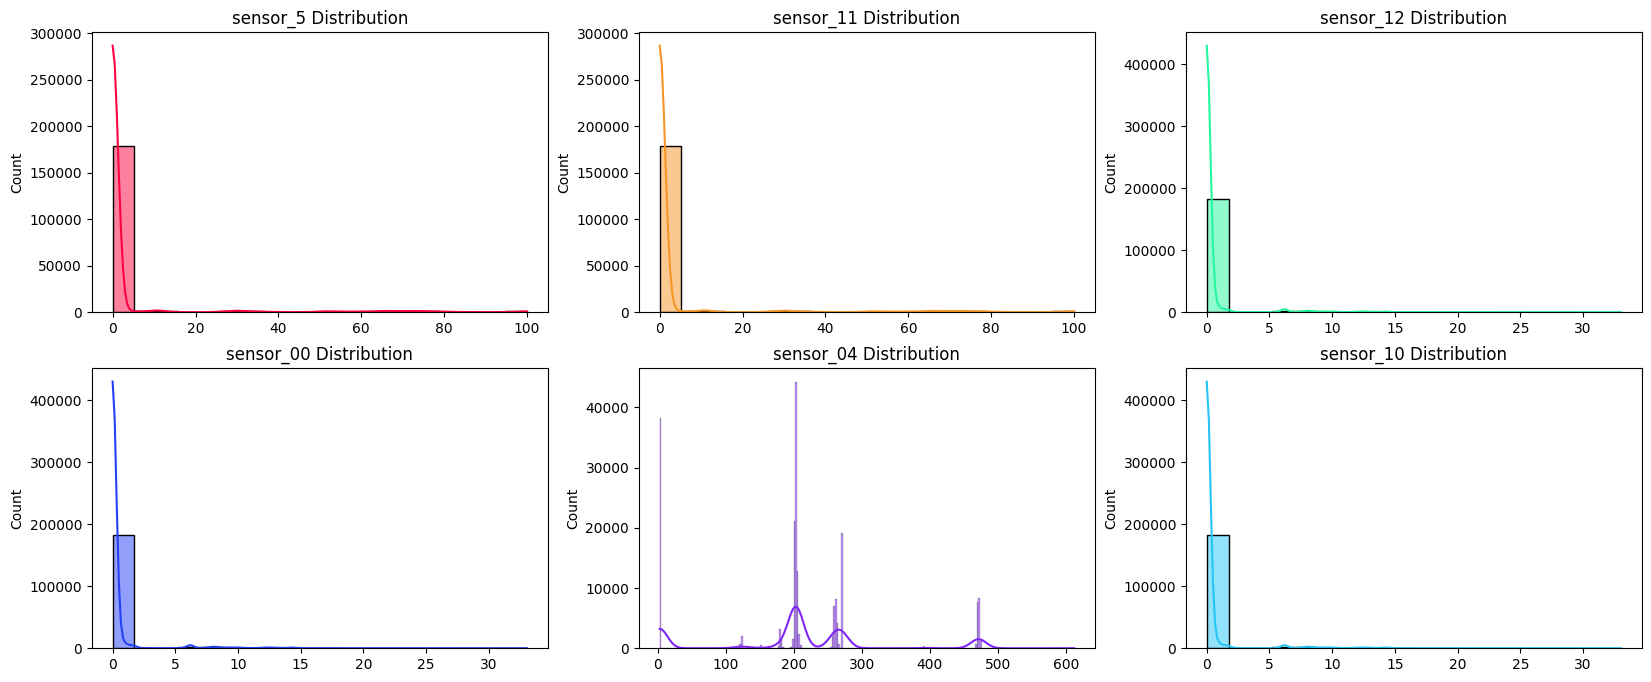

In [35]:
f, axes = plt.subplots(ncols=3,nrows=2, figsize=(20,8))
sensor_5_dist=df2['sensor_05'].loc[df2['result']==0].values
sns.histplot(sensor_5_dist,ax=axes[0][0],kde=True,color='#fc0341')
axes[0][0].set_title('sensor_5 Distribution')
# sns.displot(data=sensor_5_dist,kind="kde")

sensor_11_dist=df2['sensor_11'].loc[df2['result']==0].values
sns.histplot(sensor_5_dist,ax=axes[0][1],kde=True,color='#f79525')
axes[0][1].set_title('sensor_11 Distribution')

sensor_12_dist=df2['sensor_12'].loc[df2['result']==0].values
sns.histplot(sensor_12_dist,ax=axes[0][2],kde=True,color='#25f7a0')
axes[0][2].set_title('sensor_12 Distribution')

sensor_00_dist=df2['sensor_00'].loc[df2['result']==0].values
sns.histplot(sensor_12_dist,ax=axes[1][0],kde=True,color='#2541f7')
axes[1][0].set_title('sensor_00 Distribution')

sensor_04_dist=df2['sensor_04'].loc[df2['result']==0].values
sns.histplot(sensor_04_dist,ax=axes[1][1],kde=True,color='#8025f7')
axes[1][1].set_title('sensor_04 Distribution')

sensor_10_dist=df2['sensor_10'].loc[df2['result']==0].values
sns.histplot(sensor_12_dist,ax=axes[1][2],kde=True,color='#25c6f7')
axes[1][2].set_title('sensor_10 Distribution')

In [36]:
#Removing Outliers
d00=df2.loc[df2['result']==0]
d1=df2.loc[df2['result']==1]


In [37]:
#Removing Outliers for Sensor05 Highest Postiviely Corelated
print('Sensor 05\n')
d5=d00.sensor_05.values
q1_5=np.percentile(d5,25)
q3_5=np.percentile(d5,90)
iqr5=q3_5-q1_5
ll5=q1_5-1.5*iqr5
ul5=q3_5+1.5*iqr5
print('Lower Quartile for sensor 5: {}'.format(ll5))
print('upper Quartile for sensor 5: {}'.format(ul5))
print('All most all values in this sensor are zero')
print('---'*39)

#Removing Outliers for Sensor00 Highest Postiviely Corelated
print('Sensor 0\n')
d0=d00.sensor_00.values
q1_0=np.percentile(d0,25)
q3_0=np.percentile(d0,75)
iqr0=q3_0-q1_0
ll0=q1_0-1.5*iqr0
ul0=q3_0+1.5*iqr0
print('Lower Quartile for sensor 0: {}'.format(ll0))
print('upper Quartile for sensor 0: {}'.format(ul0))
outliers=[x for x in d0 if x<ll0 or x>ul0]
print('Number of outliers :{}'.format(len(outliers)))
dx=d00[(d00['sensor_00']>=ll0) & (d00['sensor_00']<=ul0)]
print('shape after removing the outliers: {}'.format(dx.shape))
print('---'*39)

#  Removing Outliers for Sensor04 Highest Postiviely Corelated
print('Sensor 4\n')
d4=d00.sensor_04.values
q1_0=np.percentile(d4,25)
q3_0=np.percentile(d4,75)
iqr4 =q3_0-q1_0
ll4=q1_0-1.5*iqr4
ul4=q3_0+1.5*iqr4
print('Lower Quartile for sensor 0: {}'.format(ll4))
print('upper Quartile for sensor 0: {}'.format(ul4))
outliers4=[x for x in d4 if x<ll4 or x>ul4]
print('Number of outliers :{}'.format(len(outliers4)))
dx=dx[(dx['sensor_04']>=ll4) & (dx['sensor_04']<=ul4)]
print('shape after removing the outliers: {}'.format(dx.shape))
print('---'*39)

# Removing Outliers for Sensor10 Highest Postiviely Corelated
print('Sensor 10\n')
d10=d00.sensor_10.values
q1_0=np.percentile(d10,25)
q3_0=np.percentile(d10,75)
iqr10=q3_0-q1_0
ll10=q1_0-1.5*iqr10
ul10=q3_0+1.5*iqr10
print('Lower Quartile for sensor 0: {}'.format(ll10))
print('upper Quartile for sensor 0: {}'.format(ul10))
outliers10=[x for x in d10 if x<ll10 or x>ul10]
print('Number of outliers :{}'.format(len(outliers10)))
dx=dx[(dx['sensor_10']>=ll10) & (dx['sensor_10']<=ul10)]
print('shape after removing the outliers: {}'.format(dx.shape))
print('---'*39)

# Removing Outliers for Sensor11 Highest Postiviely Corelated
print('Sensor 11\n')
d11=d00.sensor_11.values
q1_0=np.percentile(d11,25)
q3_0=np.percentile(d11,75)
iqr10=q3_0-q1_0
ll11=q1_0-1.5*iqr10
ul11=q3_0+1.5*iqr10
print('Lower Quartile for sensor 0: {}'.format(ll11))
print('upper Quartile for sensor 0: {}'.format(ul11))
outliers11=[x for x in d11 if x<ll11 or x>ul11]
print('Number of outliers :{}'.format(len(outliers11)))
dx=dx[(dx['sensor_11']>=ll11) & (dx['sensor_11']<=ul11)]
print('shape after removing the outliers: {}'.format(dx.shape))
print('---'*39)

# Removing Outliers for Sensor12 Highest Postiviely Corelated
print('Sensor 12\n')
d12=d00.sensor_12.values
q1_0=np.percentile(d12,25)
q3_0=np.percentile(d12,75)
iqr10=q3_0-q1_0
ll12=q1_0-1.5*iqr10
ul12=q3_0+1.5*iqr10
print('Lower Quartile for sensor 0: {}'.format(ll12))
print('upper Quartile for sensor 0: {}'.format(ul12))
outliers12=[x for x in d12 if x<ll12 or x>ul12]
print('Number of outliers :{}'.format(len(outliers12)))
dx=dx[(dx['sensor_12']>=ll12) & (dx['sensor_12']<=ul12)]
print('shape after removing the outliers: {}'.format(dx.shape))
print('---'*39)

Sensor 05

Lower Quartile for sensor 5: 0.0
upper Quartile for sensor 5: 0.0
All most all values in this sensor are zero
---------------------------------------------------------------------------------------------------------------------
Sensor 0

Lower Quartile for sensor 0: -0.1389582696685803
upper Quartile for sensor 0: 0.23684402979572797
Number of outliers :13921
shape after removing the outliers: (178848, 54)
---------------------------------------------------------------------------------------------------------------------
Sensor 4

Lower Quartile for sensor 0: 91.94140106584521
upper Quartile for sensor 0: 363.6414751291288
Number of outliers :57898
shape after removing the outliers: (123741, 54)
---------------------------------------------------------------------------------------------------------------------
Sensor 10

Lower Quartile for sensor 0: -1.4347019075093523
upper Quartile for sensor 0: 3.1255130041817196
Number of outliers :19227
shape after removing the outlie

In [38]:
df3=pd.concat([dx,d1],axis=0)
df3=df3.sample(frac=1)
df3

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_47,sensor_48,sensor_49,sensor_51,month,week,Day,hour,partofday,result
141316,2.519502,44.270832,51.953120,43.706596,634.375000,72.32592,14.677370,16.753470,15.733510,15.010130,...,52.372680,189.814800,55.266200,206.886600,7,3,205,23,2,1
367199,0.001968,48.046846,49.962776,44.227403,262.394979,0.00000,9.072216,17.664930,17.127556,17.580194,...,41.128989,36.912969,41.666467,38.235665,5,2,145,2,2,0
103714,2.497859,48.437500,50.564240,42.274303,632.870400,81.44167,13.302950,15.856480,14.988430,15.082470,...,44.560180,88.252310,50.925926,206.018500,6,1,166,10,0,1
111095,0.001968,36.241318,34.027775,38.368053,203.220474,0.00000,0.028935,0.036169,0.028935,0.007234,...,35.300926,29.513889,30.092590,30.960650,7,4,184,21,2,0
384112,0.111719,39.970180,37.308600,40.975990,202.390181,0.00000,11.612888,13.220692,13.236642,13.105803,...,35.300927,33.986272,32.986111,35.521968,7,4,185,15,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130630,2.499826,43.489580,49.956600,43.923611,642.592600,73.86968,14.713540,16.210940,15.697340,15.198210,...,43.692130,179.398100,44.849537,147.858800,7,2,198,12,0,1
149240,2.504745,47.092010,50.173610,43.142360,637.268494,65.44602,14.605030,16.702840,16.239870,15.588830,...,55.555560,167.824100,49.479170,215.856500,7,4,211,15,1,1
76712,2.453588,52.690970,54.861110,46.701390,638.657400,77.12237,13.469330,16.131360,15.292240,15.118630,...,43.981480,177.951400,53.819443,195.312500,5,2,147,16,1,1
84542,2.451620,47.569440,53.472221,43.142361,623.726800,67.08388,13.129340,15.661170,15.227140,14.901620,...,39.641200,176.504600,46.585650,166.088000,6,3,153,3,2,1


<AxesSubplot: xlabel='result', ylabel='count'>

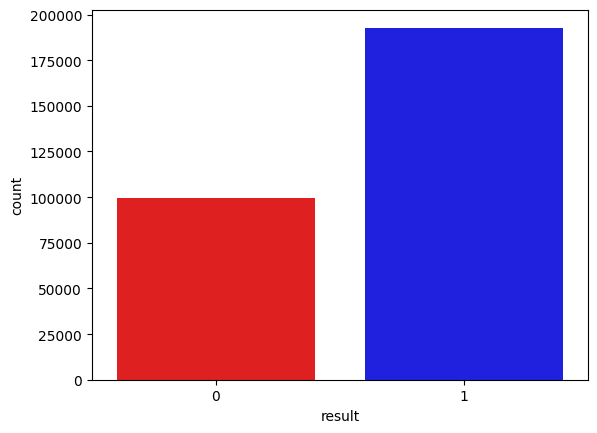

In [39]:
sns.countplot(x='result',data=df3,palette=color)

### As a trade-off for removing outliers we have again introduced a minor class imbalance

Text(0.5, 1.0, 'sensor_12 v/s result(positive Correlation)')

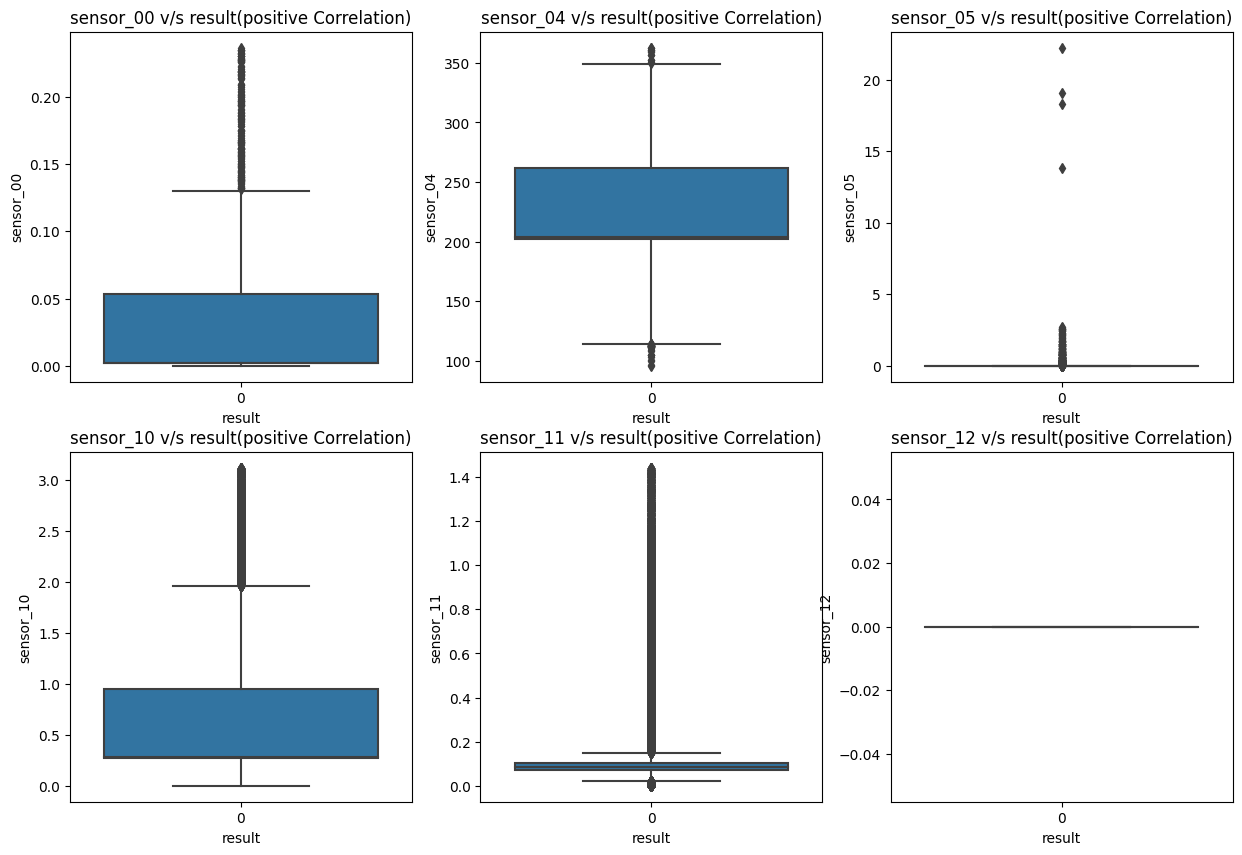

In [40]:
dp=df3.loc[df3['result']==0]
f, axes = plt.subplots(ncols=3,nrows=2, figsize=(15,10))
sns.boxplot(x='result',y='sensor_00',data=dp,ax=axes[0][0])
axes[0][0].set_title('sensor_00 v/s result(positive Correlation)')

sns.boxplot(x='result',y='sensor_04',data=dp,ax=axes[0][1])
axes[0][1].set_title('sensor_04 v/s result(positive Correlation)')

sns.boxplot(x='result',y='sensor_05',data=dp,ax=axes[0][2])
axes[0][2].set_title('sensor_05 v/s result(positive Correlation)')

sns.boxplot(x='result',y='sensor_10',data=dp,ax=axes[1][0])
axes[1][0].set_title('sensor_10 v/s result(positive Correlation)')

sns.boxplot(x='result',y='sensor_11',data=dp,ax=axes[1][1])
axes[1][1].set_title('sensor_11 v/s result(positive Correlation)')

sns.boxplot(x='result',y='sensor_12',data=dp,ax=axes[1][2])
axes[1][2].set_title('sensor_12 v/s result(positive Correlation)')

### Now We have Much Less Extreme outliers as compared to before 

## Normalizing the data

<p>The Values of Various Sensor have different Scales and this can effect the performance of our models as different weights might be given based on the values. This can severely effect the performance of our model and so We must Normalize the Data set before training.</p>

<p> Our Data is pretty sensitive to outliers so We can't use The standard Normalizing technique to our data as it can affect the performance so instead We will use Robust Scaling</p>

<b>Robust Scaling</b>
<p>Scaling using median and quantiles consists of subtracting the median to all the observations and then dividing by the interquartile difference. It Scales features using statistics that are robust to outliers.</p>


In [41]:
from sklearn.preprocessing import RobustScaler
scaler=RobustScaler()
ndf=scaler.fit_transform(df3)
ndf=pd.DataFrame(ndf,columns=df3.columns)

In [51]:
ndf

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_47,sensor_48,sensor_49,sensor_51,month,week,Day,hour,partofday,result
0,0.030433,-0.696079,0.249730,0.025886,0.015712,0.030058,0.270619,0.297951,0.168148,-0.015570,...,1.545229,0.647059,0.241320,0.155753,0.5,0.0,0.629630,1.166667,0.5,0.0
1,-1.007945,0.156857,-0.190733,0.181194,-0.974405,-0.903777,-0.900838,0.677165,0.631062,0.906482,...,0.115590,-0.389076,-0.325791,-0.852934,-0.5,-0.5,-0.481481,-0.583333,0.5,-1.0
2,0.021506,0.245099,-0.057629,-0.401231,0.011707,0.147756,-0.016630,-0.075243,-0.079267,0.010383,...,0.551867,-0.041176,0.060330,0.150561,0.0,-1.0,-0.092593,0.083333,-0.5,0.0
3,-1.007945,-2.509806,-3.717147,-1.566096,-1.131912,-0.903777,-2.790852,-6.657301,-5.046793,-5.398107,...,-0.625451,-0.439216,-0.808424,-0.896445,0.5,0.5,0.240741,1.000000,0.5,-1.0
4,-0.962677,-1.667521,-2.991101,-0.788395,-1.134122,-0.903777,-0.369847,-1.171866,-0.660975,-0.698779,...,-0.625451,-0.408909,-0.687764,-0.869164,0.5,0.5,0.259259,0.500000,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292293,0.022317,-0.872550,-0.192099,0.090601,0.037585,0.049990,0.278178,0.072231,0.156137,0.051906,...,0.441494,0.576470,-0.193057,-0.197287,0.5,-0.5,0.500000,0.250000,-0.5,0.0
292294,0.024346,-0.058824,-0.144075,-0.142372,0.023414,-0.058772,0.255500,0.276886,0.336292,0.192048,...,1.949934,0.498039,0.000000,0.209401,0.5,0.5,0.740741,0.500000,0.0,0.0
292295,0.003246,1.205883,0.893268,0.918950,0.027110,0.091987,0.018143,0.039121,0.021617,0.023356,...,0.478285,0.566667,0.180990,0.086530,-0.5,-0.5,-0.444444,0.583333,0.0,0.0
292296,0.002434,0.049019,0.585907,-0.142372,-0.012631,-0.037625,-0.052914,-0.156502,0.000000,-0.054500,...,-0.073583,0.556862,-0.120660,-0.088260,0.0,0.0,-0.333333,-0.500000,0.5,0.0


## Implemeting The Model

We Will Use Compare the Accuracy score for Logistic Regression Classification Model for Our Data Set :



In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_scor

In [45]:
X=ndf.drop('result',axis=1)
y=ndf.result
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

[[19950     0]
 [    2 38508]]
Accuracy :0.9999657885733835


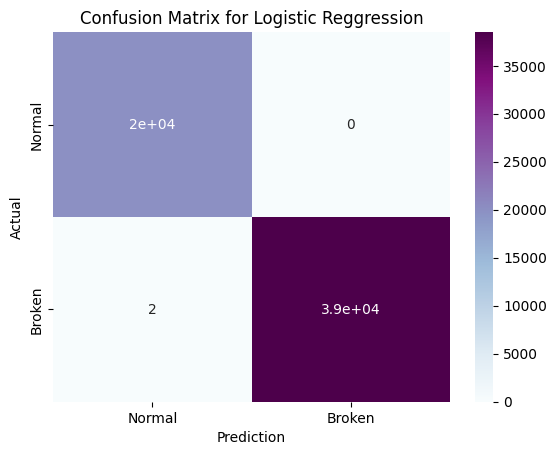

In [47]:
# Implementing Logistic Regression
mLog=LogisticRegression(max_iter=100000)
mLog.fit(X_train,y_train)
y_pred=mLog.predict(X_test)

#Creating confusion matrix
ConfusionMatrix = confusion_matrix(y_test, y_pred)
print(ConfusionMatrix)

print('Accuracy :{}'.format(accuracy_score(y_test,y_pred)))

#plotting Confusion Matrix
ax = sns.heatmap(ConfusionMatrix, annot=True, cmap='BuPu')
ax.set_title('Confusion Matrix for Logistic Reggression')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Normal','Broken'])
ax.yaxis.set_ticklabels(['Normal','Broken'])
plt.show()

In [49]:
from sklearn.model_selection import cross_val_score
training_score = cross_val_score(mLog, X_train, y_train, cv=5)
print("The Cross Validation score is :{}".format(training_score*100))
print("The Mean Score is :{}%".format(training_score.mean()*100))

The Cross Validation score is :[99.99358536 99.99786179 99.99572357 99.99358522 99.99572348]
The Mean Score is :99.99529588311967%


### Inference 
<b>Logistic Regression Works Very Well On our data set, Even With Cross Validation Model we get an acuuracy of 99.99%</b>
<p>From the Confusion Matrix we can Observe that the No of <br>
True Positive : The Number of Prediction made for machine Status is broken and Actual is broken is 39K <br>
True Negative : The Number of Prediction made for machine Status is Normal and Actual is Normal is 20K <br>
False Positive : No prediction was made Broken when the actual was normal
False Negative : 2 Predictions were made Normal when the actual was Broken
</p>

## Conclusion
<b>Creating a Mathematical Model for a complex Pipe_Network is Practically Infeasible.<br>
The Only solution That we can have Is to Use Methods of Statistics to create a model from existing Data<br>
However, The Data collected is imperfect and can't be used directly for training Models. So, the data needs to be pre-processed before training the data.
<br>
We Used Logistic Regression for creating our models.
The Model Was Able to Predict the Failure in the system with a very high accuracy of above 99%.</b>